# Geospatial Queries with Apache Sedona: A Tutorial

## Imports

In [ ]:
# Sedona Spark
from sedona.raster_utils.SedonaUtils import SedonaUtils
from sedona.spark import SedonaContext

# Pyspark imports
from pyspark.sql import SparkSession
from pyspark.sql.functions import expr

In [2]:
from pathlib import Path
from pprint import pprint
import re

import boto3
import geopandas as gpd
from matplotlib import pyplot as plt
import rasterio
from rasterio.merge import merge
from rasterio.plot import show

from IPython.display import display, HTML

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Sedona Context

In [3]:
# Initialize SedonaContext
sedona_conf = SedonaContext.builder().getOrCreate()
spark = SedonaContext.create(sedona_conf)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Constants

In [ ]:
s3_bucket = "<s3_bucket>"
prefix = "sedona-output/kianboon-temp/sample/"
s3_uri = f"s3://{s3_bucket}/{prefix}"

s3_uri

## Part 1: Importing Data into Apache Sedona

### Vector Data Processing

In [5]:
geojson_sample_file = s3_uri + "geojson_sample.json"
geojson_sample_file

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

's3://ncm-dev-bucket/sedona-output/kianboon-temp/sample/geojson_sample.json'

In [6]:
vector_df = (
    spark.read.format("geojson").option("multiLine", "true").load(geojson_sample_file)
    .selectExpr("explode(features) as features") # Explode the envelope to get one feature per row.
    .select("features.*") # Unpack the features struct.
    .withColumn("id", expr("properties['id']")).drop("properties").drop("type")
)

vector_df.createOrReplaceTempView("vector_df")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
vector_df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- geometry: geometry (nullable = true)
 |-- id: long (nullable = true)

In [8]:
vector_df = spark.sql("SELECT id, ST_SetSRID(geometry, 4326) as geometry FROM vector_df")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:
vector_df.createOrReplaceTempView("vector_df")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [10]:
vector_df.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---+--------------------+
| id|            geometry|
+---+--------------------+
|  1|POLYGON ((-61.314...|
|  2|POLYGON ((-61.427...|
|  3|POLYGON ((-61.149...|
|  4|POLYGON ((-61.430...|
|  5|POLYGON ((-60.953...|
+---+--------------------+

### Raster Data Processing

In [11]:
# use gdalwarp to convert to epsg 4326 and tiff format
sample_raster_uri_list = [s3_uri + "T20LPN_20241003T141711_B8A_20m.tif", 
                          s3_uri + "T20LQP_20241003T141711_B8A_20m.tif"]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
for i in sample_raster_uri_list:
    with rasterio.open(i) as dataset:
        print(dataset.profile)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 5553, 'height': 5479, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0001820463579509593, 0.0, -62.085099901795736,
       0.0, -0.0001820463579509593, -10.849497919967378), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 5558, 'height': 5501, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00018168202707016343, 0.0, -61.176065351746765,
       0.0, -0.00018168202707016343, -9.938937916439269), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}

In [13]:
raw_df = spark.read.format("binaryFile").load(sample_raster_uri_list)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [14]:
# Register the DataFrame as a temporary view
raw_df.createOrReplaceTempView("raw_df")
# raw_df.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [15]:
raw_df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)

In [16]:
raster_query = """
    SELECT RS_FromGeoTiff(content) AS rast, modificationTime, length, path
    FROM raw_df
"""

# Execute the query
raster_df = spark.sql(raster_query)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [17]:
raster_df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- rast: raster (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- path: string (nullable = true)

In [18]:
raster_df.createOrReplaceTempView("raster_df")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [19]:
# custom query to skip showing path to S3 bucket
# `raster_df.show()` also works
spark.sql("SELECT rast, modificationTime, length FROM raster_df").show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-------------------+--------+
|                rast|   modificationTime|  length|
+--------------------+-------------------+--------+
|GridCoverage2D["g...|2024-10-11 16:29:12|64818130|
|GridCoverage2D["g...|2024-10-11 16:29:11|64059636|
+--------------------+-------------------+--------+

In [20]:
raster_tiles_query = """
    SELECT RS_TileExplode(rast, 1, 2000, 2000, false)
    FROM raster_df
"""

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [21]:
raster_tiles_df = spark.sql(raster_tiles_query)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [22]:
raster_tiles_df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- x: integer (nullable = false)
 |-- y: integer (nullable = false)
 |-- tile: raster (nullable = false)

In [23]:
raster_tiles_df.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---+---+--------------------+
|  x|  y|                tile|
+---+---+--------------------+
|  0|  0|GridCoverage2D["g...|
|  1|  0|GridCoverage2D["g...|
|  2|  0|GridCoverage2D["g...|
|  0|  1|GridCoverage2D["g...|
|  1|  1|GridCoverage2D["g...|
+---+---+--------------------+
only showing top 5 rows

In [24]:
raster_tiles_df.createOrReplaceTempView("raster_tiles_df")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Visualization of Imported Data

In [25]:
df = vector_df.toPandas()
gdf = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [77]:
raw_datasets = []
for i in sample_raster_uri_list:
    raw_datasets.append(rasterio.open(i))
    
# Perform the merge
raw_merged_data, raw_out_transform = merge(raw_datasets)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

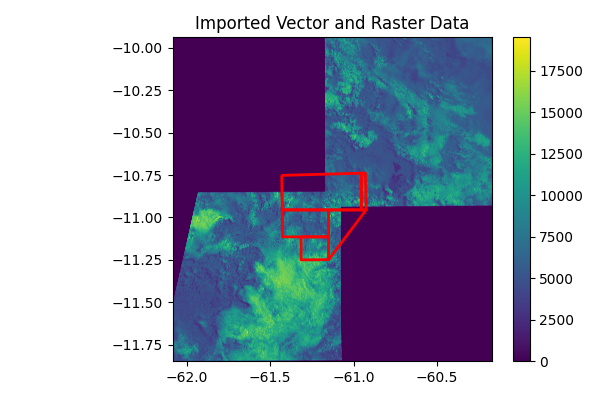

In [78]:
# Create a figure
fig, ax = plt.subplots(figsize=(6, 4))

# Plot the merged raster data
show(raw_merged_data, ax=ax, transform=raw_out_transform, cmap='viridis')

# Plot the vector data
gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)

# Add a colorbar for the raster data
plt.colorbar(ax.images[0], fraction=0.046, pad=0.04)

# Set the title
ax.set_title('Imported Vector and Raster Data')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

%matplot plt

## Part 2: Spatial Queries and Exporting Results

### Spatial Queries

#### Spatial Intersection

In [28]:
intersect_df = spark.sql("""
    SELECT
        id,
        x,
        y,
        tile,
        geometry
    FROM raster_tiles_df INNER JOIN vector_df
    ON RS_Intersects(tile, geometry)
""")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [29]:
intersect_df = intersect_df.cache()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [30]:
intersect_df.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---+---+---+--------------------+--------------------+
| id|  x|  y|                tile|            geometry|
+---+---+---+--------------------+--------------------+
|  2|  1|  0|GridCoverage2D["g...|POLYGON ((-61.427...|
|  4|  1|  0|GridCoverage2D["g...|POLYGON ((-61.430...|
|  1|  2|  0|GridCoverage2D["g...|POLYGON ((-61.314...|
|  3|  2|  0|GridCoverage2D["g...|POLYGON ((-61.149...|
|  2|  2|  0|GridCoverage2D["g...|POLYGON ((-61.427...|
|  4|  2|  0|GridCoverage2D["g...|POLYGON ((-61.430...|
|  1|  2|  1|GridCoverage2D["g...|POLYGON ((-61.314...|
|  3|  2|  1|GridCoverage2D["g...|POLYGON ((-61.149...|
|  4|  0|  2|GridCoverage2D["g...|POLYGON ((-61.430...|
|  5|  0|  2|GridCoverage2D["g...|POLYGON ((-60.953...|
+---+---+---+--------------------+--------------------+

In [31]:
intersect_df.createOrReplaceTempView("intersect_df")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### Raster Clipping

In [32]:
clipped_df = spark.sql("""
    SELECT id, x, y, RS_CLIP(tile, 1, geometry) as clipped_tile
    FROM intersect_df
""")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [33]:
clipped_df.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---+---+---+--------------------+
| id|  x|  y|        clipped_tile|
+---+---+---+--------------------+
|  2|  1|  0|GridCoverage2D["g...|
|  4|  1|  0|GridCoverage2D["g...|
|  1|  2|  0|GridCoverage2D["g...|
|  3|  2|  0|GridCoverage2D["g...|
|  2|  2|  0|GridCoverage2D["g...|
|  4|  2|  0|GridCoverage2D["g...|
|  1|  2|  1|GridCoverage2D["g...|
|  3|  2|  1|GridCoverage2D["g...|
|  4|  0|  2|GridCoverage2D["g...|
|  5|  0|  2|GridCoverage2D["g...|
+---+---+---+--------------------+

In [34]:
clipped_df.createOrReplaceTempView("clipped_df")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### Validating Results

In [35]:
rows = clipped_df.collect()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
datasets = []
transforms = []

for row in rows:
    raster = row["clipped_tile"]
    dataset = raster.as_rasterio()
    datasets.append(dataset)
    
# Perform the merge
merged_data, out_transform = merge(datasets)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

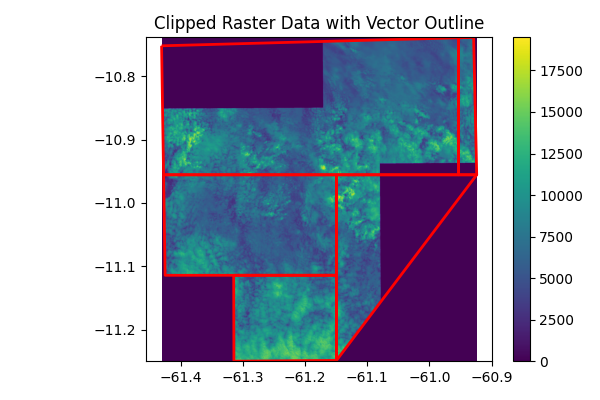

In [71]:
# Create a figure
fig, ax = plt.subplots(figsize=(6, 4))

# Plot the merged raster data
show(merged_data, ax=ax, transform=out_transform, cmap='viridis')

# Plot the vector data
gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)

# Add a colorbar for the raster data
plt.colorbar(ax.images[0], fraction=0.046, pad=0.04)

# Set the title
ax.set_title('Clipped Raster Data with Vector Outline')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

%matplot plt

### Exporting Results

In [60]:
output_path = s3_uri + "geotiff-exports"
output_path

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

's3://<s3_bucket>/sedona-output/kianboon-temp/sample/geotiff-exports'

#### Converting to GeoTIFF Format

In [43]:
# column_id needs to be unique
geotiff_df = spark.sql("""
    SELECT id, CONCAT(id, "_", x, "_", y) AS combined_id, RS_AsGeoTiff(clipped_tile) as geotiff 
    FROM clipped_df
    """)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [44]:
geotiff_df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- id: long (nullable = true)
 |-- combined_id: string (nullable = true)
 |-- geotiff: binary (nullable = true)

In [45]:
geotiff_df.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---+-----------+--------------------+
| id|combined_id|             geotiff|
+---+-----------+--------------------+
|  2|      2_1_0|[4D 4D 00 2A 00 0...|
|  4|      4_1_0|[4D 4D 00 2A 00 0...|
|  1|      1_2_0|[4D 4D 00 2A 00 0...|
|  3|      3_2_0|[4D 4D 00 2A 00 0...|
|  2|      2_2_0|[4D 4D 00 2A 00 0...|
+---+-----------+--------------------+
only showing top 5 rows

#### Writing to Storage

In [46]:
geotiff_df.write.format("raster")\
    .partitionBy("id")\
    .option("rasterField", "geotiff")\
    .option("fileExtension", ".tiff")\
    .option("pathField", "combined_id")\
    .mode("overwrite")\
    .save(output_path)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### Validating Exported Files

produced file structure will look similar to this:

```
geotiff-exports/
├── id=1/
│   └── part-00000-a41d5326-a04f-478a-bcda-6cb32caa097d.c000/
│       ├── 1_2_0.tiff
│       └── 1_2_1.tiff
├── id=2/
│   └── part-00000-a41d5326-a04f-478a-bcda-6cb32caa097d.c000/
│       ├── 2_1_0.tiff
│       └── 2_2_0.tiff
├── id=3/
│   └── part-00000-a41d5326-a04f-478a-bcda-6cb32caa097d.c000/
│       ├── 3_2_0.tiff
│       └── 3_2_1.tiff
├── id=4/
│   ├── part-00000-a41d5326-a04f-478a-bcda-6cb32caa097d.c000/
│   │   ├── 4_1_0.tiff
│   │   └── 4_2_0.tiff
│   └── part-00001-a41d5326-a04f-478a-bcda-6cb32caa097d.c000/
│       └── 4_0_2.tiff
└── id=5/
    └── part-00001-a41d5326-a04f-478a-bcda-6cb32caa097d.c000/
        └── 5_0_2.tiff
```

In [72]:
s3 = boto3.client('s3')

response = s3.list_objects_v2(Bucket=s3_bucket, Prefix=prefix + "geotiff-exports")

exported_file_path = []
for obj in response.get('Contents', []):
    if obj['Key'].lower().endswith(('.tif', '.tiff')):
        exported_file_path.append(obj['Key'])


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [73]:
# group them according to their ids
id_to_uri = dict()

for i in exported_file_path:
    vector_id = int(Path(i).stem.split("_")[0])
    relative_path = '/'.join(Path(i).parts[-3:])
    
    if vector_id not in id_to_uri:
        id_to_uri[vector_id] = []

    id_to_uri[vector_id].append(relative_path)
    
pprint(id_to_uri)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

{1: ['id=1/part-00000-a41d5326-a04f-478a-bcda-6cb32caa097d.c000/1_2_0.tiff',
     'id=1/part-00000-a41d5326-a04f-478a-bcda-6cb32caa097d.c000/1_2_1.tiff'],
 2: ['id=2/part-00000-a41d5326-a04f-478a-bcda-6cb32caa097d.c000/2_1_0.tiff',
     'id=2/part-00000-a41d5326-a04f-478a-bcda-6cb32caa097d.c000/2_2_0.tiff'],
 3: ['id=3/part-00000-a41d5326-a04f-478a-bcda-6cb32caa097d.c000/3_2_0.tiff',
     'id=3/part-00000-a41d5326-a04f-478a-bcda-6cb32caa097d.c000/3_2_1.tiff'],
 4: ['id=4/part-00000-a41d5326-a04f-478a-bcda-6cb32caa097d.c000/4_1_0.tiff',
     'id=4/part-00000-a41d5326-a04f-478a-bcda-6cb32caa097d.c000/4_2_0.tiff',
     'id=4/part-00001-a41d5326-a04f-478a-bcda-6cb32caa097d.c000/4_0_2.tiff'],
 5: ['id=5/part-00001-a41d5326-a04f-478a-bcda-6cb32caa097d.c000/5_0_2.tiff']}

In [74]:
id_to_datasets = {}
id_to_transforms = {}

for vector_id, uri_list in id_to_uri.items():
    temp_datasets = []
    for uri in uri_list:
        temp_datasets.append(rasterio.open(s3_uri + 'geotiff-exports/' + uri))
    merged_dataset, merged_out_transform = merge(temp_datasets)
    id_to_datasets[vector_id] = merged_dataset
    id_to_transforms[vector_id] = merged_out_transform

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

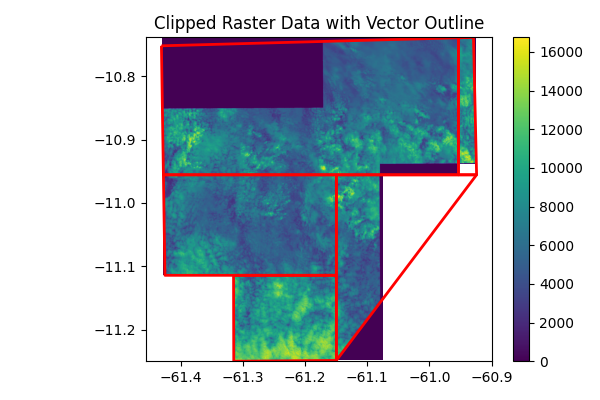

In [75]:
# Create a figure
fig, ax = plt.subplots(figsize=(6, 4))

for vector_id in id_to_datasets:
    # Plot the merged raster data
    show(id_to_datasets[vector_id], ax=ax, transform=id_to_transforms[vector_id], cmap='viridis')

# Plot the vector data for outline
gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)

# Add a colorbar for the raster data
plt.colorbar(ax.images[0], fraction=0.046, pad=0.04)

# Set the title
ax.set_title('Clipped Raster Data with Vector Outline')

plt.tight_layout()
plt.show()

%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

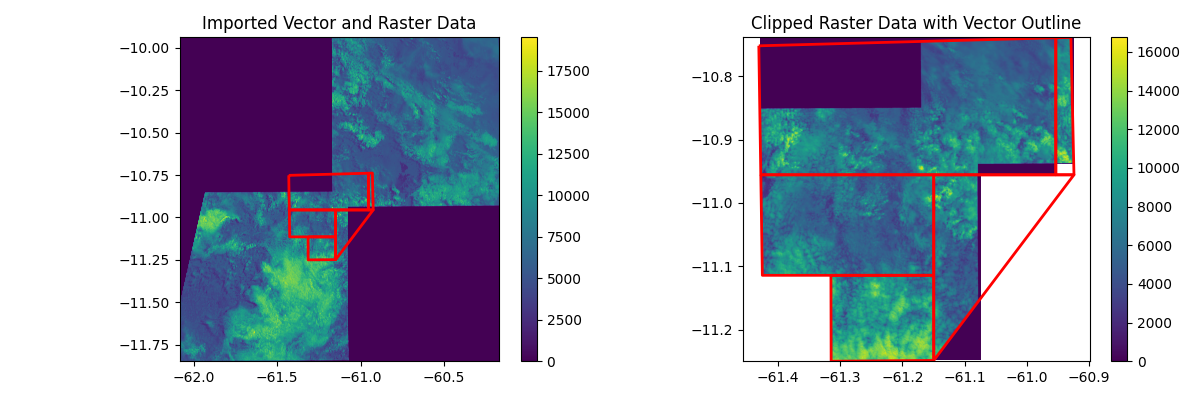

In [79]:
# side by side comparison
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# First plot (left side)
show(raw_merged_data, ax=ax1, transform=raw_out_transform, cmap='viridis')
gdf.plot(ax=ax1, facecolor='none', edgecolor='red', linewidth=2)
plt.colorbar(ax1.images[0], ax=ax1, fraction=0.046, pad=0.04)
ax1.set_title('Imported Vector and Raster Data')

# Second plot (right side)
for vector_id in id_to_datasets:
    show(id_to_datasets[vector_id], ax=ax2, transform=id_to_transforms[vector_id], cmap='viridis')
gdf.plot(ax=ax2, facecolor='none', edgecolor='red', linewidth=2)
plt.colorbar(ax2.images[0], ax=ax2, fraction=0.046, pad=0.04)
ax2.set_title('Clipped Raster Data with Vector Outline')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

%matplot plt